In [2]:
from utils import calc_entropy, cs_divergence, json_to_tileid, tileid_to_json,tilemap2heightmap
import numpy as np
from map2graph import map2digraph, get_map_shortest_length_dist, tiles2data
import os
import datetime
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import time
from WFCUnity3DEnv_fastwfc import WFCUnity3DEnv
import fastwfc

wfc_easy = fastwfc.XLandWFC("samples.xml")
# wfc_hard = fastwfc.XLandWFC("samples2.xml")
wfc_hard = fastwfc.XLandWFC("samples.xml")
file_name = "./wfc_unity2_render/mac_build/1209_mac_built.app/Contents/MacOS/tilemap_render"
unity_env = WFCUnity3DEnv(file_name=file_name)

Trying to connect to 0.0.0.0:53943


In [ ]:
wfc_easy.wave_from_id

# 随机生成一张好地图作为种子参考

[ 0  5 45  8  5 12  6]


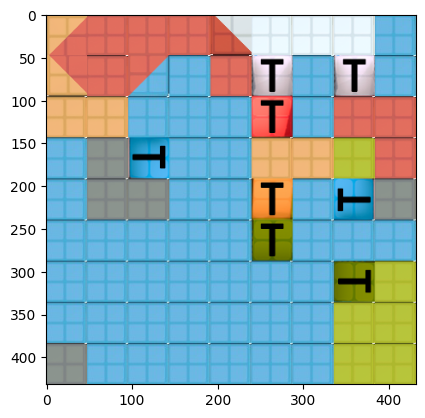

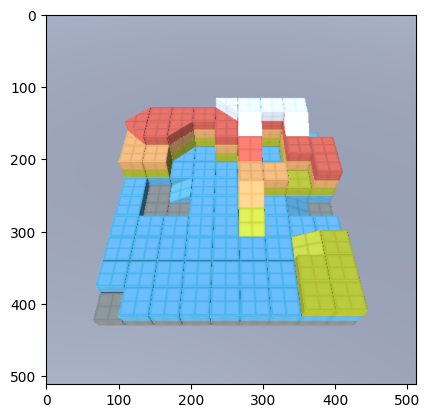

In [ ]:
ids,img = wfc_easy.generate(out_img=True) 
height_dist = np.bincount(tilemap2heightmap(ids), minlength=7)
print(height_dist)
unity_env.set_wave(ids)
img_3d = unity_env.render_in_unity()
plt.imshow(img)
plt.pause(0.1)
plt.imshow(img_3d)
plt.pause(0.1)

# 生成和种子地图相同块分布的地图

29.46183972531247
27.422618401604176
26.49528259898354
19.493588689617926
17.776388834631177
17.4928556845359
16.492422502470642
14.352700094407323
13.416407864998739
12.328828005937952
12.083045973594572
10.862780491200215
8.831760866327848
8.366600265340756
8.246211251235321
5.477225575051661
3.4641016151377544
2.8284271247461903
1.4142135623730951
0.0


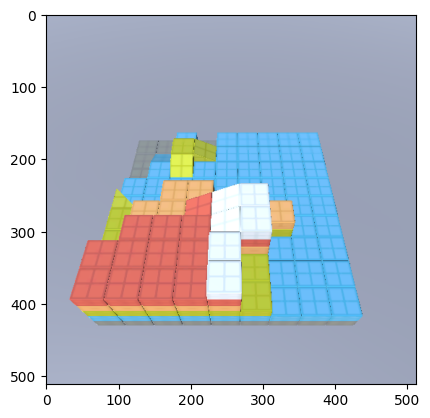

In [ ]:
new_ids,new_img = wfc_hard.generate(out_img=True) 
new_heihgt_dist = np.bincount(tilemap2heightmap(new_ids), minlength=7)
distance = np.linalg.norm(height_dist-new_heihgt_dist)
min_distance = 999999
# iter_count = 1000
wave = wfc_hard.wave_from_id(new_ids)
target_error = 1
count = 0
while distance > target_error:
    # iter_count -= 1
    new_ids,new_img = wfc_hard.mutate(base_wave=wave, out_img=False, iter_count=2, new_weight=162.0)
    new_heihgt_dist = np.bincount(tilemap2heightmap(new_ids), minlength=7)
    distance = np.linalg.norm(height_dist-new_heihgt_dist)
    count+=1
    if distance < min_distance:
        min_distance = distance
        wave = wfc_hard.wave_from_id(new_ids)
        print(distance)
        count = 0
    if count > 1000:
        new_ids,new_img = wfc_hard.generate(out_img=True) 
        wave = wfc_hard.wave_from_id(new_ids)
        min_distance = 999999
        
unity_env.set_wave(new_ids)
new_img_3d = unity_env.render_in_unity()
plt.imshow(new_img_3d)
plt.pause(0.01)

In [ ]:
max_iters = 100
map_id = 0
target_list = list(np.arange(0,1,0.1)+0.1)
error = 0.01
height_error = 25
for target in target_list:
    print(f"Generating map with diver: {target}...")
    DG = map2digraph(tiles2data(wfc.get_ids_from_wave(base_wave)))
    dist1 = get_map_shortest_length_dist(DG, norm=False)
    new_ids, _ = wfc.mutate(base_wave=base_wave,new_weight=600,iter_count=1,out_img=False)
    new_wave = wfc.wave_from_id(new_ids)
    DG2 = map2digraph(tiles2data(new_ids))
    dist2 = get_map_shortest_length_dist(DG2, norm=False)
    count = 0
    diver = np.abs(cs_divergence(dist1, dist2))
    height_distance = np.linalg.norm(target_height_map_dist - np.bincount(tilemap2heightmap(new_ids), minlength=7))
    # min_target_distance = 999
    min_fitness = 999
    while (diver > (target+error) or diver < (target-error)) or (len(np.bincount(tilemap2heightmap(new_ids)))!=3 or height_distance > height_error):
        print(f"height_distance: {height_distance}, layer: {len(np.bincount(tilemap2heightmap(new_ids)))}")
        print(f"diver: {diver}, target: {target}")
        fitness  = np.abs(diver-target) + height_distance
        count +=1
        while len(np.bincount(tilemap2heightmap(new_ids)))!=3:
            new_ids, _ = wfc.mutate(base_wave=base_wave,new_weight=162,iter_count=1,out_img=False)
        new_wave = wfc.wave_from_id(new_ids)
        DG2 = map2digraph(tiles2data(new_ids))
        dist2 = get_map_shortest_length_dist(DG2, norm=False)
        diver = cs_divergence(dist1, dist2)
        height_distance = np.linalg.norm(target_height_map_dist - np.bincount(tilemap2heightmap(new_ids), minlength=7))
        if fitness < min_fitness:
            min_fitness = fitness
            print(f"diver:{diver},height_distance:{height_distance},min_fitness:{fitness}, layer{len(np.bincount(tilemap2heightmap(new_ids)))}")
            base_wave = new_wave
    new_ids = wfc.get_ids_from_wave(new_wave)
    json_data = tileid_to_json(new_ids, save_path=os.path.join(save_path, f"{diver}.json"))
    max_iters-=1
    print(f"Done")
    print(f"{diver}.json saved")

In [1]:
import fastwfc
from WFCUnity3DEnv_fastwfc import WFCUnity3DEnv
import matplotlib.pyplot as plt
import numpy as np


layer = 6
wfc = fastwfc.XLandWFC("samples.xml")

# 根据连通性指标生成(空地参考)

In [2]:
from graph_analysis import DiGraphStats
from map2graph import map2digraph
from utils import tiles2data, tilemap2heightmap
import fastwfc
from WFCUnity3DEnv_fastwfc import WFCUnity3DEnv
import matplotlib.pyplot as plt
import numpy as np


layer = 6
wfc = fastwfc.XLandWFC("samples.xml")
empty = wfc.get_ids_from_wave(wfc.build_a_open_area_wave())
# tiles,_ = wfc.generate(out_img=False)A
DiGraph = map2digraph(tiles2data(empty))
empty_mean_all_pair_length, empty_no_path_pair_rate =DiGraphStats(DiGraph=DiGraph)
print(f"mean_all_pair_length: {empty_mean_all_pair_length}, no_path_pair_rate: {empty_no_path_pair_rate}")
ids,_ = wfc.generate(out_img=False)
base_wave = wfc.wave_from_id(ids)
DiGraph = map2digraph(tiles2data(ids))
_, no_path_pair_rate =DiGraphStats(DiGraph=DiGraph)
min_no_path_pair_rate = 1000
# min_hardness = 100
while no_path_pair_rate > 0:
    ids, _ = wfc.mutate(base_wave=base_wave,new_weight=10,iter_count=1,out_img=False)
    while len(np.bincount(tilemap2heightmap(ids))) != layer+1:
        base_wave = wfc.wave_from_id(ids)
        ids, _ = wfc.mutate(base_wave=base_wave,new_weight=10,iter_count=1,out_img=False)
        base_wave = wfc.wave_from_id(ids)
    DiGraph = map2digraph(tiles2data(ids))
    mean_all_pair_length, no_path_pair_rate =DiGraphStats(DiGraph=DiGraph)
    # hardness = 0.25 * np.abs(mean_all_pair_length - empty_mean_all_pair_length) + 0.75 * no_path_pair_rate
    if no_path_pair_rate < min_no_path_pair_rate:
        min_no_path_pair_rate = no_path_pair_rate
        base_wave = wfc.wave_from_id(ids)
        print(no_path_pair_rate)
file_name = "./wfc_unity2_render/mac_build/1209_mac_built.app/Contents/MacOS/tilemap_render"
wfc_unity = WFCUnity3DEnv(file_name=file_name)
wfc_unity.set_wave(ids)
img = wfc_unity.render_in_unity()
plt.imshow(img)
plt.pause(0.01)
os.system(f"pidof {os.path.basename(file_name)} | xargs kill -9")
    

mean_all_pair_length: 6.925925925925926, no_path_pair_rate: 0.0
0.3996342021033379
0.2639841487578113
0.10623380582228319


KeyboardInterrupt: 

# 散度指标生成(空地参考)

In [19]:
from graph_analysis import DiGraphStats
from map2graph import map2digraph, get_map_shortest_length_dist
from utils import tiles2data, tilemap2heightmap, cs_divergence
import fastwfc
from WFCUnity3DEnv_fastwfc import WFCUnity3DEnv
import matplotlib.pyplot as plt
import numpy as np

layer = 6
wfc = fastwfc.XLandWFC("samples2.xml")
empty = wfc.get_ids_from_wave(wfc.build_a_open_area_wave())
# tiles,_ = wfc.generate(out_img=False)A
empty_dist = get_map_shortest_length_dist(map2digraph(tiles2data(empty)), norm=False)
ids,_ = wfc.generate(out_img=False)
base_wave = wfc.wave_from_id(ids)
dist = get_map_shortest_length_dist(map2digraph(tiles2data(ids)), norm=False)
divergence = cs_divergence(empty_dist, dist)
# min_no_path_pair_rate = 1000
min_divergence = 100
target_divergence = 2.0
error = 0.05
reset_countreset_threshold = 500
reset_count = 0
# stop_condition = (divergence > target_divergence - error) and (divergence < target_divergence + error)
# while divergence > target_divergence and divergence < target_divergence - error:
while (divergence < target_divergence) or (divergence > (target_divergence + error)):
    ids, _ = wfc.mutate(base_wave=base_wave,new_weight=10,iter_count=1,out_img=False)
    while len(np.bincount(tilemap2heightmap(ids))) != layer+1:
        base_wave = wfc.wave_from_id(ids)
        ids, _ = wfc.mutate(base_wave=base_wave,new_weight=10,iter_count=1,out_img=False)
        base_wave = wfc.wave_from_id(ids)
    dist = get_map_shortest_length_dist(map2digraph(tiles2data(ids)), norm=False)
    divergence = cs_divergence(empty_dist, dist)
    if np.abs(divergence-target_divergence) < min_divergence:
        min_divergence = np.abs(divergence-target_divergence)
        base_wave = wfc.wave_from_id(ids)
        print(f"divergence: {divergence}, min_divergence: {min_divergence}")
    reset_count+=1
    if reset_count > reset_countreset_threshold:
        ids, _ = wfc.generate(out_img=False)
        dist = get_map_shortest_length_dist(map2digraph(tiles2data(ids)), norm=False)
        divergence = cs_divergence(empty_dist, dist)
        reset_count = 0
print(divergence)
file_name = "./wfc_unity2_render/mac_build/1209_mac_built.app/Contents/MacOS/tilemap_render"
wfc_unity = WFCUnity3DEnv(file_name=file_name)
wfc_unity.set_wave(ids)
img = wfc_unity.render_in_unity()
plt.imshow(img)
plt.pause(0.01)
os.system(f"pidof {os.path.basename(file_name)} | xargs kill -9")

divergence: 1.0582836190842626, min_divergence: 0.9417163809157374
divergence: 1.0773430124270909, min_divergence: 0.9226569875729091
divergence: 1.1465593688847755, min_divergence: 0.8534406311152245
divergence: 1.1732131644221886, min_divergence: 0.8267868355778114
divergence: 1.2924931458761502, min_divergence: 0.7075068541238498
divergence: 1.305386218151636, min_divergence: 0.694613781848364
divergence: 1.3079031370091714, min_divergence: 0.6920968629908286
divergence: 1.3168581280336937, min_divergence: 0.6831418719663063
divergence: 1.3169729261021004, min_divergence: 0.6830270738978996
divergence: 1.3190419140425071, min_divergence: 0.6809580859574929
divergence: 1.3312864228405064, min_divergence: 0.6687135771594936
divergence: 1.3456049856458485, min_divergence: 0.6543950143541515
divergence: 1.354532827942436, min_divergence: 0.645467172057564
divergence: 1.360339576478589, min_divergence: 0.639660423521411
divergence: 1.376082051575778, min_divergence: 0.6239179484242221
di

KeyboardInterrupt: 

# Array Random Sample Based(无规则随机生成器)

In [5]:
import numpy as np
import fastwfc
from WFCUnity3DEnv_fastwfc import WFCUnity3DEnv
import matplotlib.pyplot as plt
from graph_analysis import DiGraphStats
from map2graph import map2digraph
from utils import tiles2data, tilemap2heightmap

wfc = fastwfc.XLandWFC("samples.xml")
wave = wfc.build_a_open_area_wave()
wave_ids = wfc.get_ids_from_wave(wave)
base_wave_list = wave.get_data()
file_name = "./wfc_unity2_render/mac_build/1209_mac_built.app/Contents/MacOS/tilemap_render"
wfc_unity = WFCUnity3DEnv(file_name=file_name)

Trying to connect to 0.0.0.0:51548


In [26]:
class RandomMapGenerator(object):
    def __init__(self, size=81, max_index=86) -> None:
        self.prob = np.array([np.ones(max_index)/max_index for i in range(size)])
        self.data = np.ones(size, dtype=int)
        self.max_index = max_index
        self.size = size
        self.wfc = fastwfc.XLandWFC("samples.xml")
        self.base_wave = self.wfc.build_a_open_area_wave()
        self.map_ids = self.wfc.get_ids_from_wave(self.base_wave)
    
    def set_basewave(self, base_wave):
        self.base_wave = base_wave

    def generate(self):
        self.data = np.array([np.random.choice(self.max_index, p=self.prob[i]) for i in range(self.size)])
        wave = self.wfc.build_a_open_area_wave()
        wave.set_data(self.data)
        self.map_ids = self.wfc.get_ids_from_wave(wave)
        return self.map_ids

    def mutate(self, base_wave=None, weight=162):
        if base_wave is None:
            base_wave = self.base_wave
        base_wave_list = base_wave.get_data()
        weight_array = np.array([weight if base_wave_list[i] == j else 1 for i in range(self.size) for j in range(self.prob.shape[1])])
        biased_prob = self.prob * weight_array.reshape(self.prob.shape)
        # normalize biased_prob
        biased_prob = biased_prob / biased_prob.sum(axis=1, keepdims=True)
        self.data = np.array([np.random.choice(self.max_index, p=biased_prob[i]) for i in range(self.size)])
        wave = self.wfc.build_a_open_area_wave()
        wave.set_data(self.data)
        return self.wfc.get_ids_from_wave(wave)


# 无规则生成器优化非连通性

In [9]:

map_witdh = 9
map_height = 9
map_size = map_witdh * map_height

mapGen = RandomMapGenerator(size=map_size, max_index=86)
tile_ids = mapGen.generate()
# mutate_data = mapGen.mutate(weight=162)

DiGraph = map2digraph(tiles2data(tile_ids))
mean_all_pair_length, no_path_pair_rate =DiGraphStats(DiGraph=DiGraph)
print(f"mean_all_pair_length: {mean_all_pair_length}, no_path_pair_rate: {no_path_pair_rate}")
max_no_path_pair = 0
base_wave = wfc.wave_from_id(tile_ids)
while no_path_pair_rate != 1:
    tile_ids = mapGen.mutate(base_wave=base_wave, weight=1000)
    DiGraph = map2digraph(tiles2data(tile_ids))
    mean_all_pair_length, no_path_pair_rate =DiGraphStats(DiGraph=DiGraph)
    if no_path_pair_rate > max_no_path_pair:
        max_no_path_pair = no_path_pair_rate
        base_wave = wfc.wave_from_id(tile_ids)
        print(f"mean_all_pair_length: {mean_all_pair_length}, no_path_pair_rate: {no_path_pair_rate}")

wfc_unity.set_wave(tile_ids)
img = wfc_unity.render_in_unity()
plt.imshow(img)
plt.pause(0.01)


mean_all_pair_length: 5.396865203761755, no_path_pair_rate: 0.7568968145099833
mean_all_pair_length: 8.306658878504672, no_path_pair_rate: 0.4781283340954123
mean_all_pair_length: 6.45483288166215, no_path_pair_rate: 0.6625514403292181
mean_all_pair_length: 6.357307514983863, no_path_pair_rate: 0.6694101508916324
mean_all_pair_length: 6.29058211074302, no_path_pair_rate: 0.6779454351470813
mean_all_pair_length: 6.259863229879011, no_path_pair_rate: 0.7102575826855663
mean_all_pair_length: 5.327767470624614, no_path_pair_rate: 0.7535436671239141
mean_all_pair_length: 4.6255585344057195, no_path_pair_rate: 0.8294467306812986
mean_all_pair_length: 4.626824817518248, no_path_pair_rate: 0.8329522938576437
mean_all_pair_length: 4.332976445396145, no_path_pair_rate: 0.857643651882335
mean_all_pair_length: 3.868360277136259, no_path_pair_rate: 0.8680079256210943
mean_all_pair_length: 3.872241579558653, no_path_pair_rate: 0.8687700045724737
mean_all_pair_length: 3.8063725490196076, no_path_pair

KeyboardInterrupt: 

Trying to connect to 0.0.0.0:57222


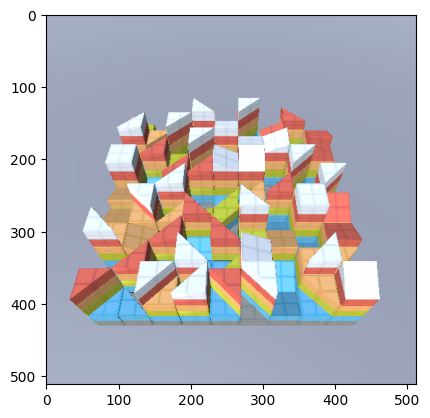

In [17]:
wfc_unity = WFCUnity3DEnv(file_name=file_name)
wfc_unity.set_wave(tile_ids)
img = wfc_unity.render_in_unity()
plt.imshow(img)
plt.pause(0.01)

# 无规则生成,空地参考的散度

In [31]:
from graph_analysis import DiGraphStats
from map2graph import map2digraph, get_map_shortest_length_dist
from utils import tiles2data, tilemap2heightmap, cs_divergence
import fastwfc
from WFCUnity3DEnv_fastwfc import WFCUnity3DEnv
import matplotlib.pyplot as plt
import numpy as np

layer = 6
wfc = fastwfc.XLandWFC("samples2.xml")

map_witdh = 9
map_height = 9
map_size = map_witdh * map_height

mapGen = RandomMapGenerator(size=map_size, max_index=86)

empty = wfc.get_ids_from_wave(wfc.build_a_open_area_wave())
# tiles,_ = wfc.generate(out_img=False)A
empty_dist = get_map_shortest_length_dist(map2digraph(tiles2data(empty)), norm=False)
ids,_ = wfc.generate(out_img=False)
base_wave = wfc.wave_from_id(ids)
dist = get_map_shortest_length_dist(map2digraph(tiles2data(ids)), norm=False)
divergence = cs_divergence(empty_dist, dist)
# min_no_path_pair_rate = 1000
min_divergence = 100
target_divergence = 2
error = 0.05
reset_countreset_threshold = 500
reset_count = 0
# stop_condition = (divergence > target_divergence - error) and (divergence < target_divergence + error)
# while divergence > target_divergence and divergence < target_divergence - error:
while (divergence < target_divergence) or (divergence > (target_divergence + error)):
    ids = mapGen.mutate(base_wave=base_wave, weight=1000)
    while len(np.bincount(tilemap2heightmap(ids))) != layer+1:
        base_wave = wfc.wave_from_id(ids)
        # ids, _ = wfc.mutate(base_wave=base_wave,new_weight=10,iter_count=1,out_img=False)
        ids = mapGen.mutate(base_wave=base_wave, weight=1000)
        base_wave = wfc.wave_from_id(ids)
    dist = get_map_shortest_length_dist(map2digraph(tiles2data(ids)), norm=False)
    divergence = cs_divergence(empty_dist, dist)
    if np.abs(divergence-target_divergence) < min_divergence:
        min_divergence = np.abs(divergence-target_divergence)
        base_wave = wfc.wave_from_id(ids)
        print(f"divergence: {divergence}, min_divergence: {min_divergence}")
    reset_count+=1
    if reset_count > reset_countreset_threshold:
        # ids, _ = wfc.generate(out_img=False)
        ids = mapGen.generate()
        dist = get_map_shortest_length_dist(map2digraph(tiles2data(ids)), norm=False)
        divergence = cs_divergence(empty_dist, dist)
        reset_count = 0
print(divergence)
file_name = "./wfc_unity2_render/mac_build/1209_mac_built.app/Contents/MacOS/tilemap_render"
wfc_unity = WFCUnity3DEnv(file_name=file_name)
wfc_unity.set_wave(ids)
img = wfc_unity.render_in_unity()
plt.imshow(img)
plt.pause(0.01)
os.system(f"pidof {os.path.basename(file_name)} | xargs kill -9")

divergence: 1.0100636094408364, min_divergence: 0.9899363905591636
divergence: 1.0381631496218313, min_divergence: 0.9618368503781687
divergence: 1.0450291377121033, min_divergence: 0.9549708622878967
divergence: 1.1306158892212157, min_divergence: 0.8693841107787843
divergence: 1.1354494068851868, min_divergence: 0.8645505931148132
divergence: 1.1754888746034693, min_divergence: 0.8245111253965307
divergence: 1.2228782608802309, min_divergence: 0.7771217391197691
divergence: 1.2650190679277855, min_divergence: 0.7349809320722145
divergence: 1.266432725487941, min_divergence: 0.7335672745120589
divergence: 1.2794158150276023, min_divergence: 0.7205841849723977
divergence: 1.3285333624138858, min_divergence: 0.6714666375861142
divergence: 1.3663031779376174, min_divergence: 0.6336968220623826
divergence: 1.3786528301387604, min_divergence: 0.6213471698612396
divergence: 1.389888015813419, min_divergence: 0.610111984186581
divergence: 1.391609595616589, min_divergence: 0.608390404383411


KeyboardInterrupt: 

Trying to connect to 0.0.0.0:55047


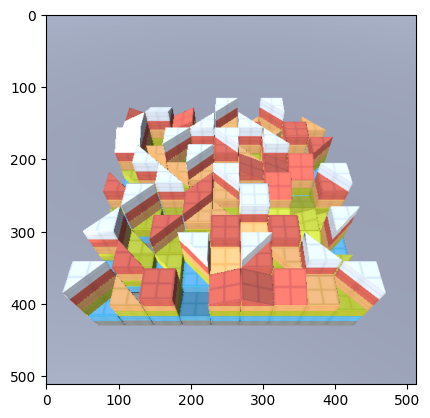

0

In [32]:
file_name = "./wfc_unity2_render/mac_build/1209_mac_built.app/Contents/MacOS/tilemap_render"
wfc_unity = WFCUnity3DEnv(file_name=file_name)
wfc_unity.set_wave(ids)
img = wfc_unity.render_in_unity()
plt.imshow(img)
plt.pause(0.01)
os.system(f"pidof {os.path.basename(file_name)} | xargs kill -9")

# 路长散度和连通度结合

NameError: name 'get_map_shortest_length_dist' is not defined

0.9308452078621546
Trying to connect to 0.0.0.0:55465


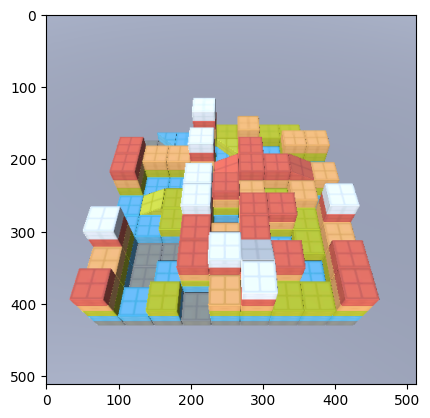

0

In [69]:
from graph_analysis import DiGraphStats
from map2graph import map2digraph, get_map_shortest_length_dist
from utils import tiles2data, tilemap2heightmap, cs_divergence
import fastwfc
from WFCUnity3DEnv_fastwfc import WFCUnity3DEnv
import matplotlib.pyplot as plt
import numpy as np

layer = 6
wfc = fastwfc.XLandWFC("samples2.xml")
empty = wfc.get_ids_from_wave(wfc.build_a_open_area_wave())
# tiles,_ = wfc.generate(out_img=False)A
empty_dist = get_map_shortest_length_dist(map2digraph(tiles2data(empty)), norm=False)
ids,_ = wfc.generate(out_img=False)
base_wave = wfc.wave_from_id(ids)
DiGraph = map2digraph(tiles2data(ids))
dist = get_map_shortest_length_dist(DiGraph, norm=False)
divergence = cs_divergence(empty_dist, dist)
mean_all_pair_length, no_path_pair_rate =DiGraphStats(DiGraph=DiGraph)
complexity = 0.5 * divergence + 0.5 * no_path_pair_rate
# min_no_path_pair_rate = 1000
min_complexity = 100
min_divergence = 105
target_complexity = 0.9
# target_divergence = 0.1
error = 0.05
reset_countreset_threshold = 500
reset_count = 0
# stop_condition = (divergence > target_divergence - error) and (divergence < target_divergence + error)
# while divergence > target_divergence and divergence < target_divergence - error:
while (complexity < target_complexity) or (complexity > (target_complexity + error)):
    ids, _ = wfc.mutate(base_wave=base_wave,new_weight=162,iter_count=1,out_img=False)
    while len(np.bincount(tilemap2heightmap(ids))) != layer+1:
        base_wave = wfc.wave_from_id(ids)
        ids, _ = wfc.mutate(base_wave=base_wave,new_weight=162,iter_count=1,out_img=False)
        base_wave = wfc.wave_from_id(ids)
    DiGraph = map2digraph(tiles2data(ids))
    dist = get_map_shortest_length_dist(DiGraph, norm=False)
    divergence = cs_divergence(empty_dist, dist)
    mean_all_pair_length, no_path_pair_rate =DiGraphStats(DiGraph=DiGraph)
    complexity = 0.5 * divergence + 0.5 * no_path_pair_rate
    if np.abs(complexity-target_complexity) < min_complexity:
        min_complexity = np.abs(complexity-target_complexity)
        base_wave = wfc.wave_from_id(ids)
        print(f"complexity: {complexity}, min_complexity_diff: {min_complexity}")
    reset_count+=1
    if reset_count > reset_countreset_threshold:
        ids, _ = wfc.generate(out_img=False)
        DiGraph = map2digraph(tiles2data(ids))
        dist = get_map_shortest_length_dist(DiGraph, norm=False)
        divergence = cs_divergence(empty_dist, dist)
        mean_all_pair_length, no_path_pair_rate =DiGraphStats(DiGraph=DiGraph)
        complexity = 0.5 * divergence + 0.5 * no_path_pair_rate
        reset_count = 0
print(complexity)
file_name = "./wfc_unity2_render/mac_build/1209_mac_built.app/Contents/MacOS/tilemap_render"
wfc_unity = WFCUnity3DEnv(file_name=file_name)
wfc_unity.set_wave(ids)
img = wfc_unity.render_in_unity()
plt.imshow(img)
plt.pause(0.01)
os.system(f"pidof {os.path.basename(file_name)} | xargs kill -9")

# 随机生成器\Complex

complexity: 0.5866483767718336, min_complexity_diff: 0.38664837677183356
complexity: 0.5564700502972107, min_complexity_diff: 0.35647005029721074
complexity: 0.547782350251486, min_complexity_diff: 0.347782350251486
complexity: 0.5208047553726566, min_complexity_diff: 0.32080475537265657
complexity: 0.4762993446121018, min_complexity_diff: 0.2762993446121018
complexity: 0.46105776558451456, min_complexity_diff: 0.26105776558451455
complexity: 0.4409388812680994, min_complexity_diff: 0.24093888126809937
complexity: 0.38195397043133666, min_complexity_diff: 0.18195397043133665
complexity: 0.27983539094650206, min_complexity_diff: 0.07983539094650205
complexity: 0.26367931717725956, min_complexity_diff: 0.06367931717725955
complexity: 0.2528577960676726, min_complexity_diff: 0.0528577960676726
complexity: 0.24157902758725805, min_complexity_diff: 0.04157902758725804
0.24157902758725805
Trying to connect to 0.0.0.0:56586


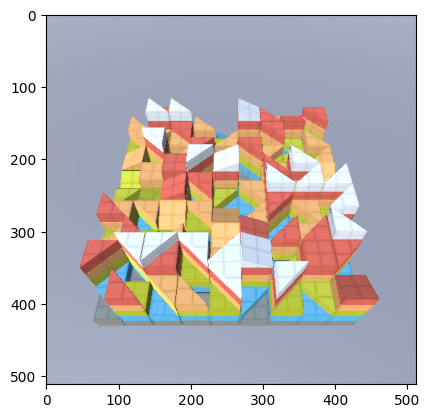

0

In [31]:
from graph_analysis import DiGraphStats
from map2graph import map2digraph, get_map_shortest_length_dist
from utils import tiles2data, tilemap2heightmap, cs_divergence
import fastwfc
from WFCUnity3DEnv_fastwfc import WFCUnity3DEnv
import matplotlib.pyplot as plt
import numpy as np

map_witdh = 9
map_height = 9
map_size = map_witdh * map_height


weight_pair = 1.0
weight_length = 0

layer = 6
wfc = fastwfc.XLandWFC("samples2.xml")
mapGen = RandomMapGenerator(size=map_size, max_index=86)
empty = wfc.get_ids_from_wave(wfc.build_a_open_area_wave())
# tiles,_ = wfc.generate(out_img=False)A
empty_dist = get_map_shortest_length_dist(map2digraph(tiles2data(empty)), norm=False)
ids= mapGen.generate()
base_wave = wfc.wave_from_id(ids)
DiGraph = map2digraph(tiles2data(ids))
dist = get_map_shortest_length_dist(DiGraph, norm=False)
divergence = cs_divergence(empty_dist, dist)
mean_all_pair_length, no_path_pair_rate =DiGraphStats(DiGraph=DiGraph)
complexity = weight_length * divergence + weight_pair * no_path_pair_rate
# min_no_path_pair_rate = 1000
min_complexity = 100
min_divergence = 100
target_complexity = 0.2
# target_divergence = 0.1
error = 0.05
reset_countreset_threshold = 500
reset_count = 0
# stop_condition = (divergence > target_divergence - error) and (divergence < target_divergence + error)
# while divergence > target_divergence and divergence < target_divergence - error:
while (complexity < target_complexity) or (complexity > (target_complexity + error)):
    ids = mapGen.mutate(base_wave=base_wave, weight=1000)
    while len(np.bincount(tilemap2heightmap(ids))) != layer+1:
        base_wave = wfc.wave_from_id(ids)
        ids = mapGen.mutate(base_wave=base_wave, weight=1000)
        base_wave = wfc.wave_from_id(ids)
    DiGraph = map2digraph(tiles2data(ids))
    dist = get_map_shortest_length_dist(DiGraph, norm=False)
    divergence = cs_divergence(empty_dist, dist)
    mean_all_pair_length, no_path_pair_rate =DiGraphStats(DiGraph=DiGraph)
    complexity = weight_length * divergence + weight_pair * no_path_pair_rate
    if np.abs(complexity-target_complexity) < min_complexity:
        min_complexity = np.abs(complexity-target_complexity)
        base_wave = wfc.wave_from_id(ids)
        print(f"complexity: {complexity}, min_complexity_diff: {min_complexity}")
    reset_count+=1
    if reset_count > reset_countreset_threshold:
        ids = mapGen.generate()
        DiGraph = map2digraph(tiles2data(ids))
        dist = get_map_shortest_length_dist(DiGraph, norm=False)
        divergence = cs_divergence(empty_dist, dist)
        mean_all_pair_length, no_path_pair_rate =DiGraphStats(DiGraph=DiGraph)
        complexity = weight_length * divergence + weight_pair * no_path_pair_rate
        reset_count = 0
print(complexity)
file_name = "./wfc_unity2_render/mac_build/1209_mac_built.app/Contents/MacOS/tilemap_render"
wfc_unity = WFCUnity3DEnv(file_name=file_name)
wfc_unity.set_wave(ids)
img = wfc_unity.render_in_unity()
plt.imshow(img)
plt.pause(0.01)
os.system(f"pidof {os.path.basename(file_name)} | xargs kill -9")

# data shuffle based

In [62]:
file_name = "./wfc_unity2_render/mac_build/1209_mac_built.app/Contents/MacOS/tilemap_render"
wfc_unity = WFCUnity3DEnv(file_name=file_name)

Trying to connect to 0.0.0.0:59575


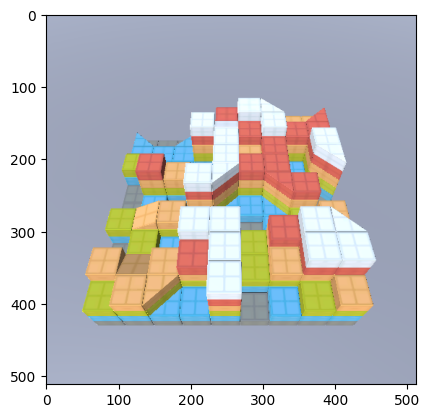

0.23680742032119867
0.3449559181394559
0.22081634722916493
0.30328798678927354
0.36948540590391843
0.27503383733882475
0.2170184659708782
0.35540420680487006
0.2528988006876677
0.20335239133376487
0.31794420440912535
0.2199408270229954
0.3154996003725247
0.2645666789784657
0.269692715447005
0.22645575928320583
0.28846554064333735
0.28304291779028934
0.311996094450835
0.35892243740984847
0.1785720335819956
0.26943778907344457
0.16668630214268745
0.28459111665001363
0.23826088959919056
0.22064957882052252
0.30788576293597375
0.1931749912493508
0.21394865215221978
0.2197521169441417
0.15706088032576537
0.26685819692831414
0.2605524091195669
0.2729335112135895
0.15484293382556222
0.1805326158575588
0.2984292061776235
0.27724742285376297
0.2526313963497137
0.2471796653937841
0.2249225062477899
0.15266663062312616
0.3782806368717753
0.30813249667476134
0.25323458005753824
0.19473139305074363
0.23114235420623264
0.15905017936778276
0.2874980863788243
0.2347860267967038
0.17919282480764195
0.3

KeyboardInterrupt: 

In [63]:
base_ids, _ = wfc.generate(out_img=False)
wfc_unity.set_wave(base_ids)
img = wfc_unity.render_in_unity()
plt.imshow(img)
plt.pause(0.01)
base_wave = wfc.wave_from_id(base_ids)
base_dist = get_map_shortest_length_dist(map2digraph(tiles2data(base_ids)), norm=False)
data = base_wave.get_data()
shulled_data = np.random.permutation(data)
# print(shulled_data)
shulled_wave = wfc.build_a_open_area_wave()
shulled_wave.set_data(shulled_data)
ids = wfc.get_ids_from_wave(shulled_wave)
shuffled_dist = get_map_shortest_length_dist(map2digraph(tiles2data(ids)), norm=False)
diver = cs_divergence(base_dist, shuffled_dist)
while diver > 0.01:
    print(diver)
    shulled_data = np.random.permutation(data)
    # print(shulled_data)
    shulled_wave = wfc.build_a_open_area_wave()
    shulled_wave.set_data(shulled_data)
    ids = wfc.get_ids_from_wave(shulled_wave)
    shuffled_dist = get_map_shortest_length_dist(map2digraph(tiles2data(ids)), norm=False)
    diver = cs_divergence(base_dist, shuffled_dist)
# print(diver)
wfc_unity.set_wave(ids)
img = wfc_unity.render_in_unity()
plt.imshow(img)
plt.pause(0.01)
# os.system(f"pidof {os.path.basename(file_name)} | xargs kill -9")

# All Map 散度 

In [10]:
from graph_analysis import DiGraphStats
from map2graph import map2digraph, get_map_shortest_length_dist
from utils import tiles2data, tilemap2heightmap, cs_divergence
import fastwfc
from WFCUnity3DEnv_fastwfc import WFCUnity3DEnv
import matplotlib.pyplot as plt
import numpy as np
import os
from utils import json_to_tileid
from natsort import natsorted
from glob import glob

json_path = "./stimulus_jsons/"
wfc = fastwfc.XLandWFC("samples.xml")
empty = wfc.get_ids_from_wave(wfc.build_a_open_area_wave())
empty_dist = get_map_shortest_length_dist(map2digraph(tiles2data(empty)), norm=False)
all_json_files = natsorted(glob(json_path+"*.json"))
all_map_diver = {}
for i,json_file in enumerate(all_json_files):
    ids = json_to_tileid(json_file)
    dist = get_map_shortest_length_dist(map2digraph(tiles2data(ids)), norm=False)
    divergence = cs_divergence(empty_dist, dist)
    all_map_diver[i] = divergence
print(all_map_diver)


{0: 0.4877662247694829, 1: 0.3969763732779157, 2: 0.4822586570886356, 3: 0.44713883048497793, 4: 0.40036995412210596, 5: 0.41784499664893276, 6: 0.42613688163622016, 7: 0.2721230965950306, 8: 0.6380163072767798, 9: 0.5056188436784719, 10: 0.5862843311751146, 11: 0.6319680408460338, 12: 0.15509233840023195, 13: 0.40255921921431254, 14: 0.40372440709149104, 15: 0.3826582559506768, 16: 0.7033642466395481, 17: 0.4272656271108057, 18: 0.5984476849628128, 19: 0.30498113091184526, 20: 0.4243703057858732, 21: 0.37877525266766576, 22: 0.5730527193013952, 23: 0.5847869314314017, 24: 0.3735003356663729, 25: 0.43001873728132095, 26: 0.49942295817629107, 27: 0.3211335911123152, 28: 0.605055981395412, 29: 0.2835500725951954, 30: 0.9799498432969882, 31: 1.0499999041143986, 32: 0.8097004144030759, 33: 1.173154646005365, 34: 0.49578626755448474, 35: 1.0274642772404183, 36: 0.7068274753097549, 37: 1.1830545842970763, 38: 0.9594699785034866, 39: 1.0830006296023988, 40: 0.9286446822674306, 41: 0.951174581

Result: Human sorted each image scores and EmptyDivergence of each image
Spearmans correlation: 0.671
Pearsons correlation: 0.698


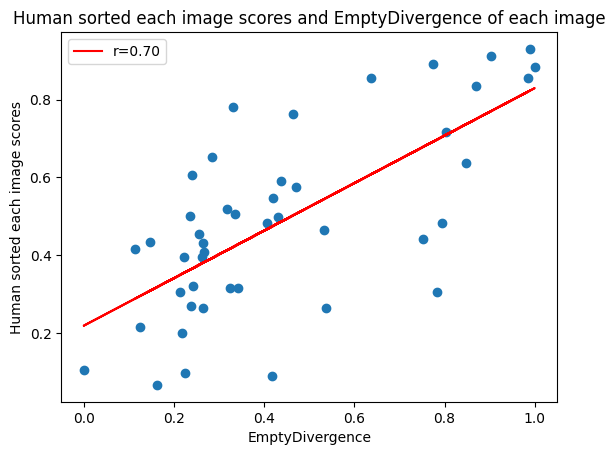

In [39]:
# min max norm
normed_diver = {}
for i, diver in all_map_diver.items():
    normed_diver[i] = (diver - min(all_map_diver.values()))/(max(all_map_diver.values())-min(all_map_diver.values()))
# print(normed_diver)
# sorted_normed_diver = {k: v for k, v in sorted(normed_diver.items(), key=lambda item: item[1])}
key_sorted_normed_diver = [(name, score) for name, score in normed_diver.items()]
np_key_sorted_normed_diver = np.array(key_sorted_normed_diver)
# print(np_key_sorted_normed_diver)
human_sorted_each_image_scores = np.load("./sorted_each_image_scores.npy", allow_pickle=True)
# 分析np_key_sorted_normed_diver和human_sorted_each_image_scores的Spearman 相关系数和pearson 相关系数
from scipy.stats import spearmanr, pearsonr
s_corr, _ = spearmanr(np_key_sorted_normed_diver[:,1], human_sorted_each_image_scores[:,1])
P_corr, _ = pearsonr(np_key_sorted_normed_diver[:,1], human_sorted_each_image_scores[:,1])
print(f"Result: Human sorted each image scores and EmptyDivergence of each image")
print('Spearmans correlation: %.3f' % s_corr)
print('Pearsons correlation: %.3f' % P_corr)
# plot np_key_sorted_normed_diver and human_sorted_each_image_scores, show the correlation
plt.figure()
plt.plot(np_key_sorted_normed_diver[:,1], human_sorted_each_image_scores[:, 1], 'o')
plt.xlabel("EmptyDivergence")
plt.ylabel("Human sorted each image scores")
plt.title("Human sorted each image scores and EmptyDivergence of each image")
# plot its r line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(np_key_sorted_normed_diver[:,1], human_sorted_each_image_scores[:, 1])
line = slope*np_key_sorted_normed_diver[:,1]+intercept
plt.plot(np_key_sorted_normed_diver[:,1], line, 'r', label=f'r={r_value:.2f}')
plt.legend()
plt.show()

# AI 游玩

# 对all_node_pair进行下采样

In [123]:
input_arr = np.random.rand(531)
R = 150
split_arr = np.linspace(0, len(input_arr)-1, num=R, dtype=int)
print(len(input_arr[split_arr]))

150
